# OPTICS
---

In [1]:
%matplotlib notebook

## Imports

In [2]:
import heapq
import math
import matplotlib.colors as mcolors
import matplotlib.markers as mmarkers

from collections import Counter
from itertools import chain, groupby, zip_longest 
from matplotlib import pyplot as plt
from operator import itemgetter
from random import randrange, random, sample
from scipy.spatial import KDTree
from statistics import mean


from typing import Callable, List, Optional, Tuple

## Algorithm

In [3]:
NOISE = -1

In [4]:
def optics(points: List[Tuple], eps: float, min_points: int) -> Tuple[List[float], List[int]]:
    """OPTICS clustering.

    Args:
        points: A list of points to cluster.
        eps: The radius `epsilon` of the dense regions.
        min_points: The minimum number of points that needs to be within a distance `eps` for a point to be a core point.

    Returns:
        A list of points indices, and their reachability distance. The first list is an ordering on `points`,
        while the second list follows the order of the elements of `points`.
        So 
    """

    def core_distance(distances: List[float]) -> Optional[float]:
        if len(distances) < min_points:
            return None
        return distances[min_points - 1]

    def update(neighbors: List[int], distances: List[float], p: int, seeds: List[Tuple[float, int]]) -> \
            List[Tuple[float, int]]:
        core_dist = core_distance(distances)
        n_d = zip(neighbors, distances)

        for q, dist in n_d:
            if not processed[q]:
                new_r_dist = max(core_dist, dist)
                old_r_dist = reachability_distances[q]
                if old_r_dist is None:
                    reachability_distances[q] = new_r_dist
                    heapq.heappush(seeds, (new_r_dist, q))
                elif new_r_dist < old_r_dist:
                    reachability_distances[q] = new_r_dist
                    for i in range(len(seeds)):
                        if seeds[i][1] == q:
                            seeds[i] = (new_r_dist, q)
                    # It would be more efficient with an implementation of a "update priority"
                    heapq.heapify(seeds)
        return seeds

    n = len(points)
    processed = [False] * n
    reachability_distances: List[Optional[float]] = [None] * n
    kd_tree = KDTree(points)
    ordered_list = []

    for p in range(n):
        if processed[p]:
            continue

        ordered_list.append(p)
        processed[p] = True
        p_distances, p_neighbors = kd_tree.query(points[p], k=None, distance_upper_bound=eps)

        if core_distance(p_distances) is not None:
            #reachability_distances[p] = core_distance(p_distances)
            seeds: List[Tuple[float, int]] = []
            seeds = update(p_neighbors, p_distances, p, seeds)
            while len(seeds) > 0:
                (_, q) = heapq.heappop(seeds)
                q_distances, q_neighbors = kd_tree.query(points[q], k=None, distance_upper_bound=eps)
                processed[q] = True
                ordered_list.append(q)
                if core_distance(q_distances) is not None:
                    seeds = update(q_neighbors, q_distances, q, seeds)

    return reachability_distances, ordered_list

In [5]:
def optics_to_clusters(ordering: List[int], reachability_distances: List[float], eps: float):
    """ Take the results from OPTICS clustering algorithm and a threshold for epsilon, and form clusters.
        To form the clusters, scans the dataset's reachability distances in the same order as they were processed
        by OPTICS; points are added to the same cluster until a point with reachability distance > eps (or equal to
        None) is found.
    Args:
        ordering: An indirect ordering array: the order in which points in the dataset where processed by OPTICS.
        reachability_distances: The list of reachability distances for each point in the dataset. This array has the
        same ordering as points in the dataset.
        eps: Cutoff value for the reachability distance: points with larger values will be considered outliers.

    Returns:
        An array with the cluster index for each point in the original dataset.
    """
    n = len(ordering)
    cluster_indices = [NOISE] * n
    current_cluster = 0
    increment_cluster_index = False
    for i in range(n):
        r_dist = reachability_distances[ordering[i]]
        if r_dist is not None and r_dist <= eps:
            if increment_cluster_index:
                current_cluster += 1
                # the first point of a cluster will always have r_dist == None
                cluster_indices[ordering[i-1]] = current_cluster
            cluster_indices[ordering[i]] = current_cluster
            increment_cluster_index = False
        else:
            increment_cluster_index = True
    return cluster_indices

## Dataset Creation

In [6]:
def create_spherical_cluster(centroid, radius, n_points):
    def random_point_in_circle():
        alpha = random() * 2 * math.pi
        r = radius * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_circle() for _ in range(n_points)] 

In [7]:
def create_ring_cluster(centroid, inner_radius, outer_radius, n_points):
    def random_point_in_ring():
        alpha = random() * 2 * math.pi
        r = inner_radius + (outer_radius - inner_radius) * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_ring() for _ in range(n_points)]

In [8]:
def create_linear_cluster(centroid, length, n_points, alpha=0):
    delta = length / n_points
    step = 0.
    
    def random_point_in_segment(step, displacement_x):
        x = centroid[0] + step * math.cos(alpha) + displacement_x
        y = centroid[1] + step * math.sin(alpha)
        return (x, y)

    points = []
    for i in range(n_points):
        step += (0.5 + random() / 2) * delta
        for _ in range(randrange(1, 10)):
            displacement_x = random() * delta * 2 - delta
            points.append(random_point_in_segment(step, displacement_x))
            
    return points

In [9]:
def create_spiral_cluster(centroid, radius, n_points):
    a_delta = 10 * math.pi / n_points
    r_delta = radius / n_points  
    s = math.sqrt(radius)

    def random_point_in_spiral(index, alpha):
        x = centroid[0] + index * r_delta * (0.95 + random() * 0.1) * math.cos(alpha) #+ (random() * s - s)
        y = centroid[1] + index * r_delta * (0.95 + random() * 0.1) * math.sin(alpha) #+ (random() * s - s)
        return (x, y)
    
    
    alpha = 0.
    radius = 0.
    points = []
    for i in range(n_points):
        step = 0.1 + random() * 0.4
        alpha += a_delta * step
        for _ in range(randrange(1, 10)):
            points.append(random_point_in_spiral(i, alpha))
            step = random() * 0.1
            alpha += a_delta * step
    return points 

In [10]:
def random_point(radius):
    return (random() * radius - radius / 2, random() * radius - radius / 2)

## Plotting

In [11]:
def __group_points_by_cluster(points: List[Tuple], cluster_indices: List[int]) -> List[List[Tuple]]:
    """Takes a list of points and another list with their cluster_indices, groups the points by cluster_indices and
       returns the list of points.

    Args:
        points: The list of points to group.
        cluster_indices: The list of cluster indices for the points. Must reflect the order of `points`.

    Returns:
        A list of clusters, where each cluster is a list of points.
    """
    n = len(points)
    get_point_label = lambda i: cluster_indices[i]
    clusters = groupby(sorted(range(n), key=get_point_label), key=get_point_label)
    return [[points[i] for i in group] for _, group in clusters]

In [12]:
def plot_points(ax, points, color, marker='o'):
    X, Y = zip(*points)
    ax.plot(X, Y, marker=marker, linestyle='none', markersize=8, markerfacecolor=color, markeredgewidth=1, markeredgecolor='k')

    
def plot_clusters(points, labels, point_markers=[], title='DBSCAN', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        ax.set_aspect('equal')
        fig.canvas.draw()
    clusters = __group_points_by_cluster(points, labels)
    k = len(clusters)
    
    if -1 in labels:
        point_markers = ['x'] + point_markers
        colors = ['k'] + list(mcolors.TABLEAU_COLORS.keys())[:k-1]
    else:
        colors = list(mcolors.TABLEAU_COLORS.keys())[:k]
    
    point_markers = point_markers[:k]
   
    for cluster, color, marker in zip_longest(clusters, colors, point_markers, fillvalue='o'):
        plot_points(ax, cluster, color, marker)

In [35]:
def plot_reachability_distances(ax: plt.Axes, ordering: List[int], reachability_distances: List[float], labels: List[int], eps: float):
    reachability_distances = [x if x is not None else eps for x in reachability_distances]
    unique_labels = set(labels)
    k = len(unique_labels)
    if -1 in unique_labels:
        colors = ['k']  + list(mcolors.TABLEAU_COLORS.keys())[:k-1]
    else:
        colors = list(mcolors.TABLEAU_COLORS.keys())[:k]
    
    domain = range(len(ordering))
    
    unique_labels = sorted(list(unique_labels))
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        distances = list(map(lambda j: reachability_distances[ordering[j]] if labels[ordering[j]] == label else 0, domain))
        #ax.plot(domain, distances, color=colors[i], ds='steps', fillstyle='full')
        ax.fill_between(domain, 0, distances, facecolor=colors[label], interpolate=False, step='pre')
    ax.axhline(y=eps, color='k')

In [32]:
def reachability_plot(points: List[Tuple[float]], ordering: List[int], reachability_distances: List[float], eps: float):
    cluster_indices = optics_to_clusters(ordering, reachability_distances, eps)
    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.suptitle('OPTICS')
    
    plot_clusters(points, cluster_indices, ['s', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'], ax=ax1)
    plot_reachability_distances(ax2, ordering, reachability_distances, cluster_indices, eps)
    fig.canvas.draw()
    

## Experiments
---

In [25]:
C5 = create_spherical_cluster((-2,0), 2, 50) + create_spherical_cluster((2,2), 0.5, 20) + create_spherical_cluster((2,0.78), 0.25, 10)

In [26]:
r_d, order = optics(C5, 50, 2)

<IPython.core.display.Javascript object>


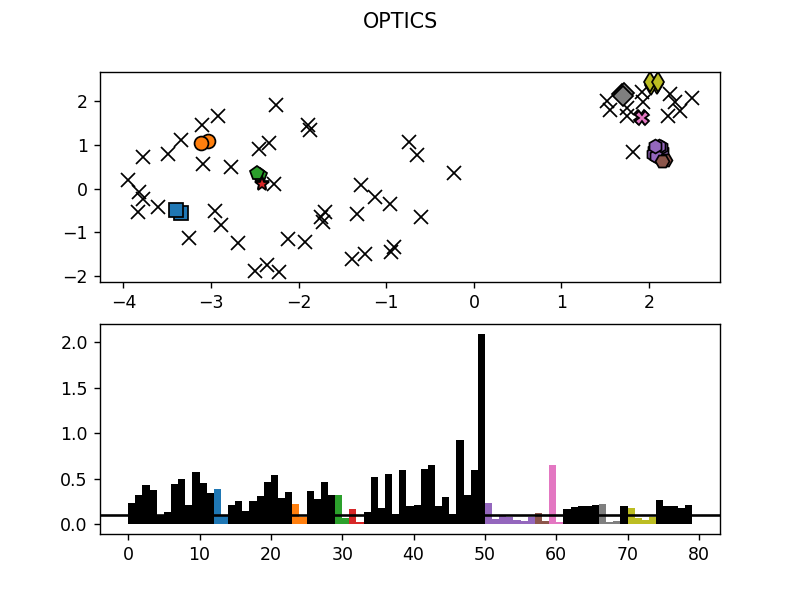

In [27]:
reachability_plot(C5, order, r_d, 0.1)

In [28]:
labels = optics_to_clusters(order, r_d, 0.6)

<IPython.core.display.Javascript object>


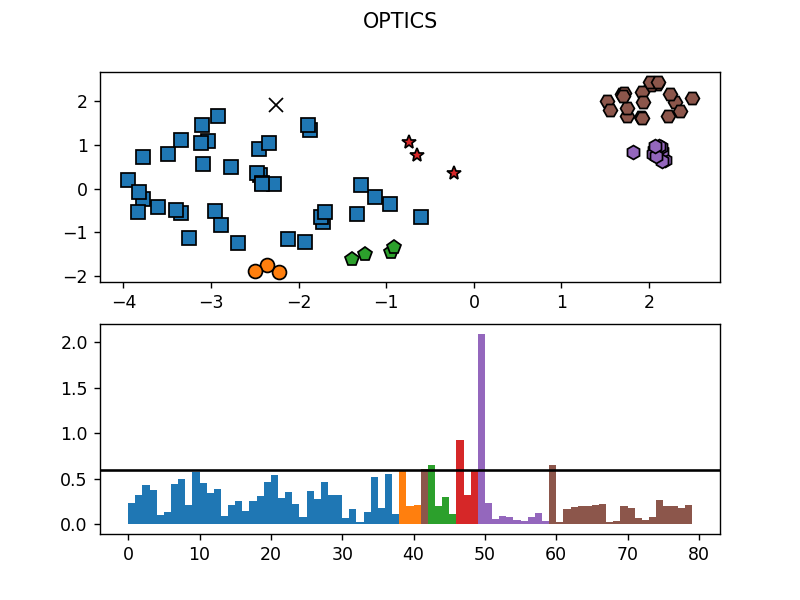

In [33]:
reachability_plot(C5, order, r_d, 0.6)

<IPython.core.display.Javascript object>


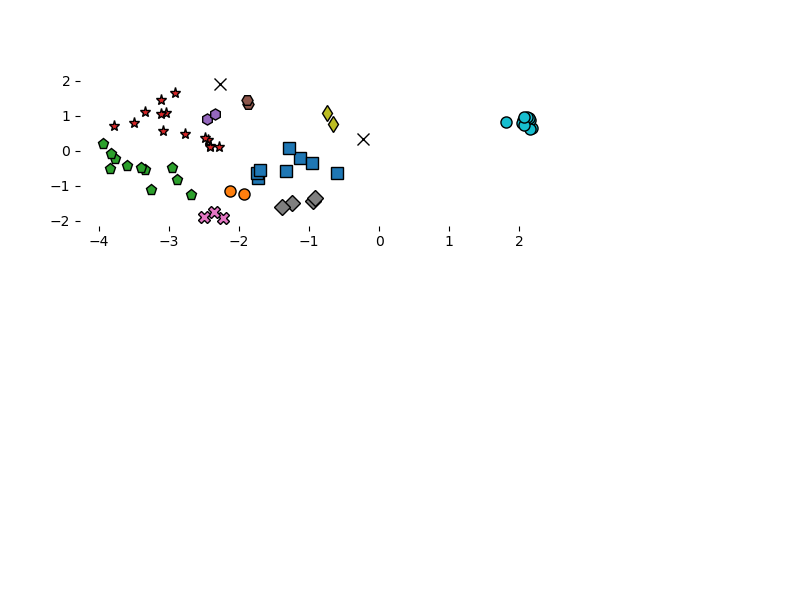

ValueError: Invalid RGBA argument: 'o'

In [36]:
reachability_plot(C5, order, r_d, 0.5)